# Triplet Learning for Food Image Similarity

This notebook demonstrates the complete pipeline for learning food image similarity using triplet loss and CLIP embeddings. We'll explore the theoretical foundations, examine the data, and show how the model learns to distinguish between similar and dissimilar food images.

## Table of Contents
1. [Task Introduction](#1-task-introduction)
2. [Data Exploration](#2-data-exploration)
3. [Triplet Loss Theory](#3-triplet-loss-theory)
4. [Model Architecture](#4-model-architecture)
5. [Training](#5-training)
6. [Inference Examples](#6-inference-examples)
7. [Future Improvements](#7-future-improvements)


In [1]:
# Import required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import pandas as pd
from pathlib import Path
import sys
import random
from typing import Tuple, List, Dict

# Add src to path for imports
sys.path.append('src')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Configure matplotlib
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("Environment setup complete!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device available: {'CUDA' if torch.cuda.is_available() else 'CPU'}")


Environment setup complete!
PyTorch version: 2.6.0
Device available: CPU


## 1. Task Introduction

### Problem Statement

Given two food images, we want to determine whether they belong to the **same category** or **different categories**. This is a fundamental problem in computer vision with applications in:

- **Food recommendation systems**
- **Dietary tracking applications**
- **Restaurant menu organization**
- **Content-based image retrieval**

## 2. Data Exploration

Let's explore our triplet dataset to understand the structure and visualize some examples.


In [2]:
# Import utility functions
from utils.notebook_utils import (
    load_triplet_data, 
    visualize_triplet
)

# Load datasets
train_triplets = load_triplet_data('src/data/splits/train_triplets.txt')
test_triplets = load_triplet_data('src/data/splits/test_triplets.txt')

print("\nDataset Statistics:")
print(f"Training triplets: {len(train_triplets):,}")
print(f"Test triplets: {len(test_triplets):,}")
print(f"Total triplets: {len(train_triplets) + len(test_triplets):,}")

# Show sample triplets if data loaded successfully
if len(train_triplets) > 0:
    print("\nSample Training Triplets:")
    print(train_triplets.head())
else:
    print("\nNo training data loaded. Please check if the files exist and have the correct format.")
    print("Expected format: anchor_id positive_id negative_id (space-separated)")



Dataset Statistics:
Training triplets: 59,515
Test triplets: 59,544
Total triplets: 119,059

Sample Training Triplets:
  anchor positive negative
0  02461    03450    02678
1  02299    02499    04987
2  04663    01056    03029
3  04532    01186    01297
4  03454    03809    02204


Sample Triplets from Training Data:

Triplet 1:
Anchor: 02461, Positive: 03450, Negative: 02678


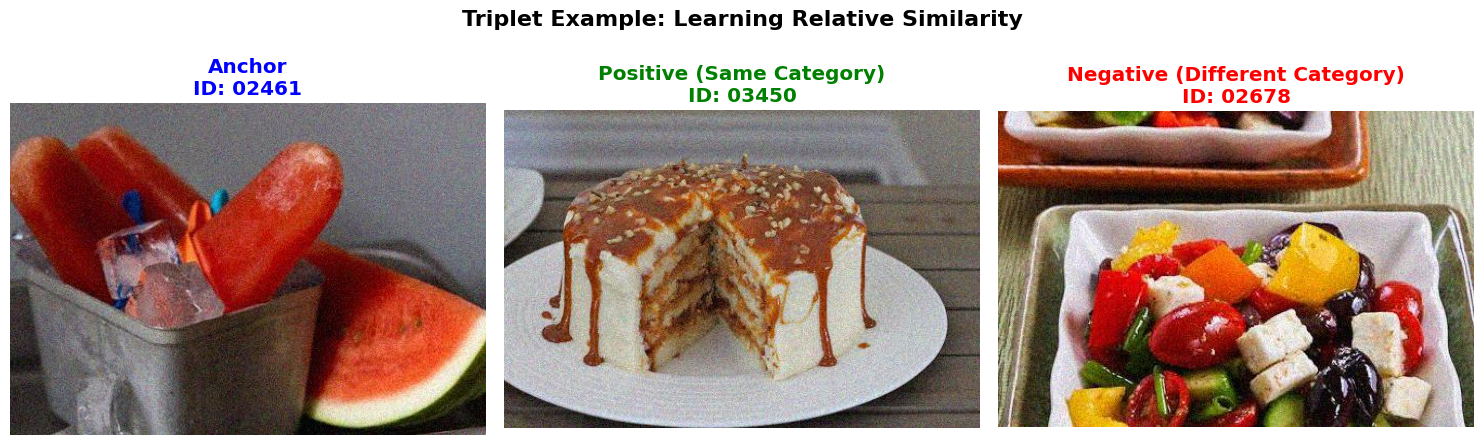


Triplet 2:
Anchor: 02299, Positive: 02499, Negative: 04987


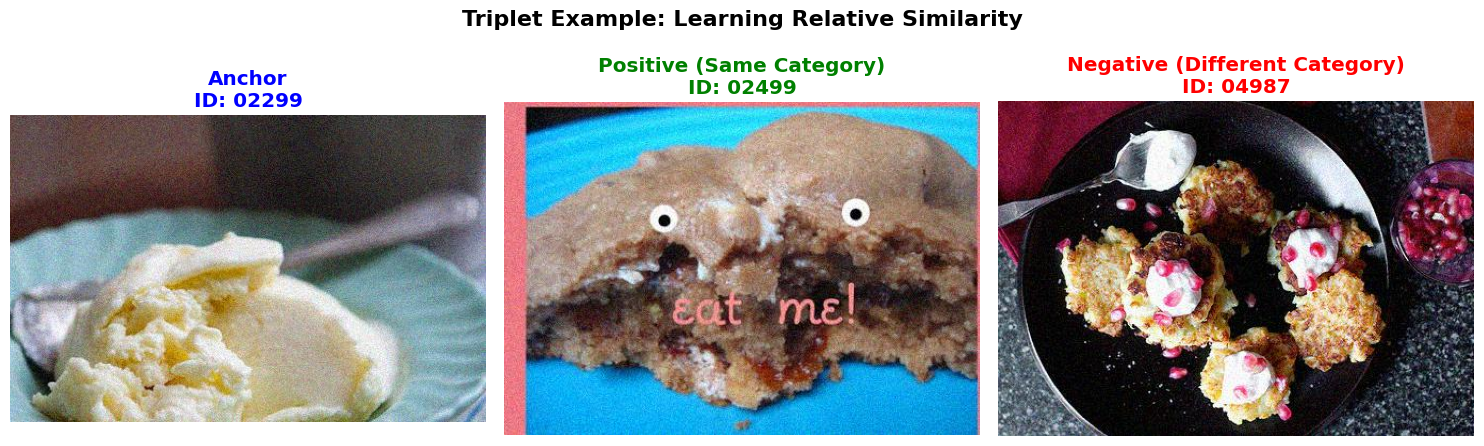

In [3]:
# Show a few sample triplets if data is available

print("Sample Triplets from Training Data:")

# Check if images directory exists
images_dir = Path('src/data/food_images')

# Show up to 2 triplets
for i in range(min(2, len(train_triplets))):
    row = train_triplets.iloc[i]
    print(f"\nTriplet {i+1}:")
    print(f"Anchor: {row['anchor']}, Positive: {row['positive']}, Negative: {row['negative']}")
    visualize_triplet(row['anchor'], row['positive'], row['negative'])

Let's prepare the triplets for training. First let's make sure that there no common images between the training and test triplets. 

In [4]:
from utils.notebook_utils import ids_from_df

train_ids = ids_from_df(train_triplets, triplet_cols=["anchor", "positive", "negative"])
test_ids = ids_from_df(test_triplets, triplet_cols=["anchor", "positive", "negative"])

common_ids = train_ids & test_ids

print(f"Found {len(common_ids)} common IDs.")
if common_ids:
    print("Examples:", ", ".join(sorted(list(common_ids))[:20]))

Found 0 common IDs.


Now let's make the train and validation split, ensuring that no image ends up being in both splits.

In [5]:
from src.data.create_splits import TripletSplitter

splitter = TripletSplitter(split_ratio=0.8, seed=42, verbose=False)

splitter.create_splits(
    train_triplets_file="src/data/splits/train_triplets.txt",
    output_dir="src/data/splits"
)

{'original_train': 59515,
 'clean_train': 30095,
 'clean_val': 457,
 'discarded': 28963,
 'train_ids': 4000,
 'val_ids': 1000,
 'split_ratio': 0.8,
 'seed': 42}

We see that in order to avoid leakage, we had to discard approximately 29K triplets, leaving us with 30K triplets for training, which is still a reasonable number. 

The new triplets files are  `src/data/splits/train_triplets_clean.txt` and `src/data/splits/val_triplets_clean.txt`.

## 3. Task formulation

### Approach: Triplet Learning

Instead of training a traditional classifier, we use **triplet learning** to learn a similarity metric. The key insight is that we learn from **relative comparisons**:

- Given three images: **anchor (A)**, **positive (P)**, **negative (N)**
- **Positive** image belongs to the same category as the anchor
- **Negative** image belongs to a different category than the anchor
- We train the model to make the anchor closer to the positive than to the negative

### Why Triplet Loss?

1. **Metric Learning**: Learns a meaningful distance metric in embedding space
2. **Relative Learning**: Focuses on relative distances rather than absolute classifications
3. **Robust Features**: Creates embeddings that generalize well to unseen categories, which are useful in zero-shot downstream tasks
4. **Scalability**: Can handle new categories without retraining the entire model

Essentially, we aim to bring anchor and positive embeddings as close as possible in the embedding space, while pushing anchor and negative embeddings as far apart as possible, thereby encoding image similarity relationships.

This is illustrated by the following figures. 

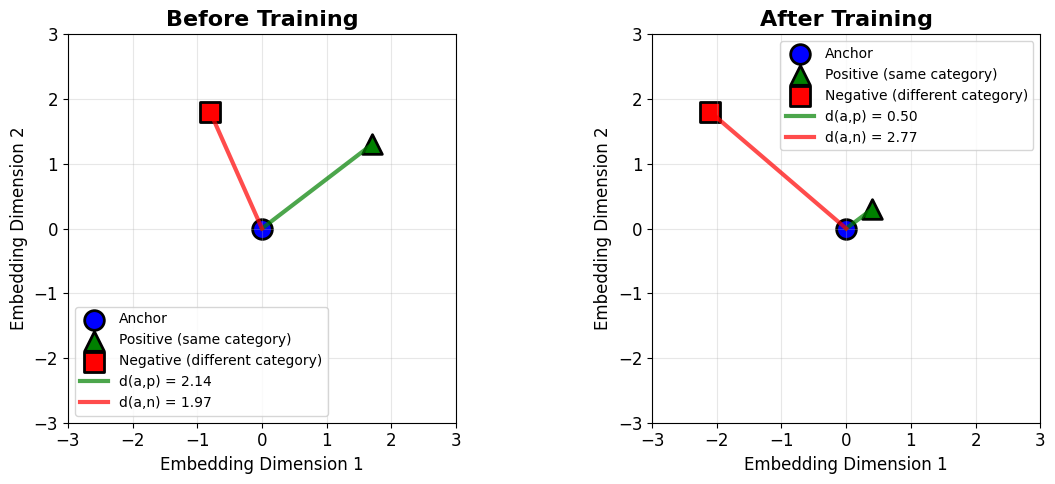

Triplet Learning Outcome:
BEFORE: d(a,p) = 2.14, d(a,n) = 1.97
        Correctly ordered? False
AFTER:  d(a,p) = 0.50, d(a,n) = 2.77
        Correctly ordered? True

Goal achieved: d(a,p) < d(a,n) ✓


In [6]:
# Simple Single Triplet Visualization: Before vs After Training
from utils.notebook_utils import plot_single_triplet_before_after

# Run the visualization
plot_single_triplet_before_after()

## Mathematical Formulation

The triplet loss is designed to learn embeddings where similar items are close together and dissimilar items are far apart.

### 3.1 Embedding Function

Let $f: \mathcal{X} \rightarrow \mathbb{R}^d$ be our embedding function that maps input images to $d$-dimensional vectors:

$$f(x) = \text{NN}(\text{CLIP}(x))$$

Where:
- $\text{CLIP}(x)$ extracts a 768-dimensional feature vector
- $\text{NN}(\cdot)$ is our neural network that maps to a lower-dimensional embedding space

### 3.2 Distance Metric

We use the **Euclidean distance** between normalized embeddings:

$$d(x_i, x_j) = \|\hat{f}(x_i) - \hat{f}(x_j)\|_2$$

Where $\hat{f}(x) = \frac{f(x)}{\|f(x)\|_2}$ is the L2-normalized embedding.

### 3.3 Triplet Loss Function

For a triplet $(a, p, n)$ where:
- $a$ is the anchor image
- $p$ is a positive image (same category as anchor)
- $n$ is a negative image (different category from anchor)

The triplet loss is defined as:

$$\mathcal{L}_{\text{triplet}}(a, p, n) = \max(0, d(a, p) - d(a, n) + \alpha)$$

Where:
- $d(a, p)$ is the distance between anchor and positive
- $d(a, n)$ is the distance between anchor and negative  
- $\alpha > 0$ is the margin parameter

### 3.4 Objective

The goal is to minimize the total loss over all triplets:

$$\mathcal{L} = \frac{1}{N} \sum_{i=1}^{N} \mathcal{L}_{\text{triplet}}(a, p_i, n_i)$$

This encourages:
- $d(a, p) < d(a, n) - \alpha$ (anchor closer to positive than negative by at least margin $\alpha$)
- Similar images to have small distances
- Dissimilar images to have large distances


### 3.5 Accuracy Metrics

We evaluate the model using two complementary accuracy metrics:

#### 3.5.1 Triplet Accuracy

Measures how often the model correctly orders triplets:

$$\text{Triplet Accuracy} = \frac{1}{N} \sum_{i=1}^{N} \mathbb{1}[d(a_i, p_i) < d(a_i, n_i)]$$

Where $\mathbb{1}[\cdot]$ is the indicator function.

#### 3.5.2 Binary Classification Accuracy

For practical applications, we convert similarity to binary decisions using a threshold $\tau$:

$$\text{similarity}(x_i, x_j) = \frac{1}{1 + d(x_i, x_j)}$$

$$\text{same\_category}(x_i, x_j) = \begin{cases} 
1 & \text{if } \text{similarity}(x_i, x_j) \geq \tau \\
0 & \text{otherwise}
\end{cases}$$

## 4. Model Architecture

Our triplet learning model is implemented using PyTorch Lightning and designed to transform CLIP embeddings into a learned similarity space optimized for food image classification.

The model uses the same embedding network with shared weights to process all three components (anchor, positive, negative) of each triplet. This is the defining characteristic of **Siamese networks**: identical sub-networks that learn to map inputs into a shared embedding space for similarity comparison.

### 4.1 Network Architecture

The model follows a simple but effective two-layer architecture:

```
Input: CLIP Embeddings (768-dim)
    ↓
Linear Layer (768 → 256)
    ↓
PReLU Activation
    ↓
Batch Normalization
    ↓
Alpha Dropout (p=0.3)
    ↓
Linear Layer (256 → 256)
    ↓
L2 Normalization (optional)
    ↓
Output: Food Embeddings (256-dim)
```

### 4.2 Design Choices

**Siamese Architecture**: The core principle is that the same `embedding_network` with identical weights processes all three images in each triplet. This shared parameter approach ensures consistency and enables the model to learn a unified embedding space.

**Input Processing**: The model takes triplets of CLIP embeddings as input with shape `(batch_size, 3, 768)`, where the 3 dimensions correspond to [anchor, positive, negative] images.

**Activation Function**: We use **PReLU** (Parametric ReLU) instead of standard ReLU, which allows learning negative slopes and often provides better gradient flow.

**Normalization**: **Batch normalization** helps stabilize training and speeds up convergence.

**Regularization**: **Alpha dropout** (instead of standard dropout) maintains the self-normalizing property and works better with PReLU activations.

**Output Normalization**: **L2 normalization** of final embeddings ensures all vectors lie on the unit sphere, making cosine similarity equivalent to dot product and improving metric learning performance.

### 4.3 Hyperparameters

| Parameter | Default Value | Description |
|-----------|---------------|-------------|
| `input_dim` | 768 | CLIP embedding dimension |
| `hidden_dim` | 256 | Hidden layer and output dimension |
| `margin` | 0.3 | Triplet loss margin (α) |
| `dropout_prob` | 0.3 | Alpha dropout probability |
| `learning_rate` | 1e-4 | SGD learning rate |
| `normalize_embeddings` | True | L2 normalize final embeddings |

### 4.4 Forward Pass

The forward pass processes each component of the triplet through the same embedding network:

1. **Input Separation**: Split triplet input into anchor, positive, and negative components
2. **Shared Embedding**: Apply the same embedding network to all three components
3. **Normalization**: L2 normalize each embedding (if enabled)
4. **Output Stacking**: Return stacked embeddings as `(3, batch_size, hidden_dim)`

This architecture ensures that the same transformation is applied to all images, allowing the model to learn a consistent embedding space where similar foods are close together and dissimilar foods are far apart.



## 5. Training

Let's train the model!



In [ ]:
from train import main

main()

Seed set to 42
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/nikolaosmourdoukoutas/repos/triplet-taste/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:658: Checkpoint directory /Users/nikolaosmourdoukoutas/repos/triplet-taste/logs/checkpoints exists and is not empty.


Starting training with default configuration...
Starting Triplet Loss Training
Setting up TripletModel...
Model configuration: {'input_dim': 768, 'hidden_dim': 256, 'margin': 0.4, 'dropout_prob': 0.1, 'learning_rate': 0.0001, 'normalize_embeddings': True}
Model created with 263,169 trainable parameters
Setting up FoodDataModule...
Data module created successfully
Setting up PyTorch Lightning Trainer...

Experiment: triplet_taste
Log directory: logs
Seed: 42

Starting training...
Setting up data for stage: fit
Loading training embeddings from src/data/embeddings/X_train_clip.pt
Loaded training embeddings: torch.Size([30621, 3, 768])
Created training dataset with 30621 samples
Loading validation embeddings from src/data/embeddings/X_val_clip.pt
Loaded validation embeddings: torch.Size([460, 3, 768])
Created validation dataset with 460 samples



  | Name              | Type       | Params | Mode 
---------------------------------------------------------
0 | embedding_network | Sequential | 263 K  | train
---------------------------------------------------------
263 K     Trainable params
0         Non-trainable params
263 K     Total params
1.053     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode
/Users/nikolaosmourdoukoutas/repos/triplet-taste/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:476: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
Metric val_accuracy improved. New best score: 0.922                              
Epoch 0, global step 30: 'val_accuracy' reached 0.92174 (best 0.92174), saving model to '/Users/nikolaosmourdoukoutas/repos/triplet-taste/logs/checkpoints/epoch=00-val-accuracy=0.0000.ckpt' as top 3


Epoch 0: train_loss=0.2779, train_acc=0.9736, val_loss=0.2627, val_acc=0.9217, lr=1.00e-04


Metric val_accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.924  
Epoch 1, global step 60: 'val_accuracy' reached 0.92391 (best 0.92391), saving model to '/Users/nikolaosmourdoukoutas/repos/triplet-taste/logs/checkpoints/epoch=01-val-accuracy=0.0000-v1.ckpt' as top 3


Epoch 1: train_loss=0.2418, train_acc=0.9467, val_loss=0.2556, val_acc=0.9239, lr=1.00e-04


Metric val_accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.928  
Epoch 2, global step 90: 'val_accuracy' reached 0.92826 (best 0.92826), saving model to '/Users/nikolaosmourdoukoutas/repos/triplet-taste/logs/checkpoints/epoch=02-val-accuracy=0.0000-v1.ckpt' as top 3


Epoch 2: train_loss=0.2322, train_acc=0.9584, val_loss=0.2534, val_acc=0.9283, lr=1.00e-04


Epoch 3, global step 120: 'val_accuracy' reached 0.92609 (best 0.92826), saving model to '/Users/nikolaosmourdoukoutas/repos/triplet-taste/logs/checkpoints/epoch=03-val-accuracy=0.0000-v1.ckpt' as top 3


Epoch 3: train_loss=0.2244, train_acc=0.9589, val_loss=0.2510, val_acc=0.9261, lr=1.00e-04


Epoch 4, global step 150: 'val_accuracy' was not in top 3                        


Epoch 4: train_loss=0.2192, train_acc=0.9601, val_loss=0.2514, val_acc=0.9239, lr=1.00e-04


Epoch 5, global step 180: 'val_accuracy' was not in top 3                        


Epoch 5: train_loss=0.2141, train_acc=0.9612, val_loss=0.2512, val_acc=0.9217, lr=1.00e-04


Epoch 6, global step 210: 'val_accuracy' was not in top 3                        


Epoch 6: train_loss=0.2096, train_acc=0.9627, val_loss=0.2503, val_acc=0.9239, lr=1.00e-04


Epoch 7, global step 240: 'val_accuracy' was not in top 3                        


Epoch 7: train_loss=0.2053, train_acc=0.9647, val_loss=0.2502, val_acc=0.9196, lr=1.00e-04


Epoch 8, global step 270: 'val_accuracy' was not in top 3                        


Epoch 8: train_loss=0.2006, train_acc=0.9663, val_loss=0.2495, val_acc=0.9174, lr=1.00e-04


Epoch 9, global step 300: 'val_accuracy' was not in top 3                        


Epoch 9: train_loss=0.1968, train_acc=0.9669, val_loss=0.2506, val_acc=0.9174, lr=1.00e-04


Epoch 10, global step 330: 'val_accuracy' was not in top 3                        


Epoch 10: train_loss=0.1941, train_acc=0.9680, val_loss=0.2511, val_acc=0.9174, lr=1.00e-04


Epoch 11, global step 360: 'val_accuracy' was not in top 3                        


Epoch 11: train_loss=0.1904, train_acc=0.9699, val_loss=0.2519, val_acc=0.9196, lr=1.00e-04


Monitored metric val_accuracy did not improve in the last 10 records. Best score: 0.928. Signaling Trainer to stop.
Epoch 12, global step 390: 'val_accuracy' was not in top 3


Epoch 12: train_loss=0.1871, train_acc=0.9703, val_loss=0.2508, val_acc=0.9174, lr=1.00e-04


Restoring states from the checkpoint path at /Users/nikolaosmourdoukoutas/repos/triplet-taste/logs/checkpoints/epoch=02-val-accuracy=0.0000-v1.ckpt
Loaded model weights from the checkpoint at /Users/nikolaosmourdoukoutas/repos/triplet-taste/logs/checkpoints/epoch=02-val-accuracy=0.0000-v1.ckpt



Testing best model...
Setting up data for stage: test
Loading test embeddings from src/data/embeddings/X_test_clip.pt
Loaded test embeddings: torch.Size([59544, 3, 768])
Created test dataset with 59544 samples


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.7658370137214661     │
│         test_loss         │    0.47537729144096375    │
└───────────────────────────┴───────────────────────────┘

Training Complete!
Best model: /Users/nikolaosmourdoukoutas/repos/triplet-taste/logs/checkpoints/epoch=02-val-accuracy=0.0000-v1.ckpt
Best val_accuracy: 0.9283
Test results: [{'test_loss': 0.47537729144096375, 'test_accuracy': 0.7658370137214661}]
Metrics saved to: logs/triplet_taste_20250808_201954_metrics.json
CSV logs saved to: logs/csv_logs/

Training Summary:
Best model path: /Users/nikolaosmourdoukoutas/repos/triplet-taste/logs/checkpoints/epoch=02-val-accuracy=0.0000-v1.ckpt
Best validation loss: 0.9283
Total epochs: 13
Test results: [{'test_loss': 0.47537729144096375, 'test_accuracy': 0.7658370137214661}]
Metrics saved to: logs/triplet_taste_20250808_201954_metrics.json

To analyze training results, open the analysis notebook:
jupyter notebook analysis.ipynb


{'best_model_path': '/Users/nikolaosmourdoukoutas/repos/triplet-taste/logs/checkpoints/epoch=02-val-accuracy=0.0000-v1.ckpt',
 'best_model_score': tensor(0.9283),
 'test_results': [{'test_loss': 0.47537729144096375,
   'test_accuracy': 0.7658370137214661}],
 'total_epochs': 13,
 'global_step': 390,
 'metrics_file': 'logs/triplet_taste_20250808_201954_metrics.json'}

**We see that model converged quickly and generalizes relatively well with $76\%$ test accuracy.**

## 6. Inference Examples
Let's demonstrate how to use our trained model for real-world food similarity prediction using new, out-of-sample images. We'll load two food images and determine if they belong to the same category.


In [ ]:
# Load required libraries for inference
import clip
from PIL import Image
from pathlib import Path
from src.models.triplet_model import TripletModel

# Load the trained model
checkpoint_dir = Path("logs")
checkpoint_files = list(checkpoint_dir.glob("**/*.ckpt"))
    
best_checkpoint = max(checkpoint_files, key=lambda x: x.stat().st_mtime)
print(f"Loading model from: {best_checkpoint}")


trained_model = TripletModel.load_from_checkpoint(str(best_checkpoint))
trained_model.eval()
device = next(trained_model.parameters()).device
print("✓ Model loaded successfully!")

Loading model from: logs/checkpoints/last-v1.ckpt
✓ Model loaded successfully!
Loading CLIP model...


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
    (ln_pre): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
          )
          (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=1024, out_features=4096, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=4096, out_features=1024, bias=True)
          )
          (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)


Initializing FoodSimilarityPredictor...
Using device: cpu
Loading CLIP encoder...
CLIP ViT-L/14 encoder loaded successfully (768-dim embeddings)
Loading triplet model from: logs/checkpoints/last-v1.ckpt
Triplet model loaded successfully
Model parameters: 263,169
Food similarity predictor initialized successfully!
Out-of-Sample Test Images


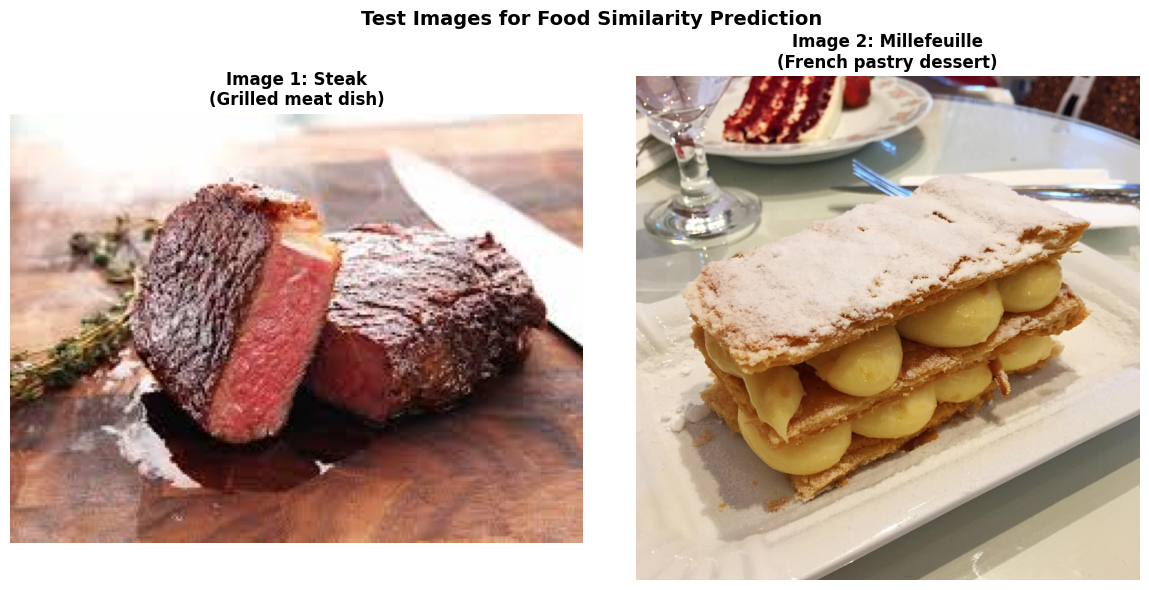

These are two clearly different food categories:
• Steak: A savory grilled meat dish
• Millefeuille: A sweet French pastry with layers
Our model should predict them as DIFFERENT categories.

Food Similarity Prediction
Image 1: src/data/inference_images/steak.jpeg
Image 2: src/data/inference_images/millefeuille.jpg

Loading image 1: src/data/inference_images/steak.jpeg
Loading image 2: src/data/inference_images/millefeuille.jpg
Extracting CLIP embeddings...
Computing learned embeddings...
Similarity: 0.3804
Same category prediction: False
✗ The model predicts these are from DIFFERENT food categories


In [20]:
from src.inference.predictor import FoodSimilarityPredictor

# Initialize the food similarity predictor
print("Initializing FoodSimilarityPredictor...")
predictor = FoodSimilarityPredictor(
    model_checkpoint_path=best_checkpoint,
    similarity_threshold=0.5,
    device="auto"
)


# First, let's examine our out-of-sample test images
image1_path = "src/data/inference_images/steak.jpeg"
image2_path = "src/data/inference_images/millefeuille.jpg"

print("Out-of-Sample Test Images")
print("=" * 40)

# Display the images
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

image1 = Image.open(image1_path)
image2 = Image.open(image2_path)

axes[0].imshow(image1)
axes[0].set_title("Image 1: Steak\n(Grilled meat dish)", fontsize=12, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(image2)
axes[1].set_title("Image 2: Millefeuille\n(French pastry dessert)", fontsize=12, fontweight='bold')
axes[1].axis('off')

plt.suptitle("Test Images for Food Similarity Prediction", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("These are two clearly different food categories:")
print("• Steak: A savory grilled meat dish")
print("• Millefeuille: A sweet French pastry with layers")
print("Our model should predict them as DIFFERENT categories.")
print()

# Now make prediction
print("Food Similarity Prediction")
print("=" * 50)
print(f"Image 1: {image1_path}")
print(f"Image 2: {image2_path}")
print()

# Make prediction
result = predictor.predict_same_category(image1_path, image2_path, return_details=True)

# Display results
print(f"Similarity: {result['similarity_score']:.4f}")
print(f"Same category prediction: {result['same_category']}")

if result['same_category']:
    print("✓ The model predicts these are from the SAME food category")
else:
    print("✗ The model predicts these are from DIFFERENT food categories")


## 7. Future improvements

To enhance the model's generalization performance, several advanced techniques could be implemented:

### 1. CLIP Fine-tuning
- **Fine-tune the CLIP encoder head** instead of treating it as a frozen feature extractor
- This would allow the visual encoder to adapt specifically to food imagery characteristics
- Could improve feature quality for food-specific visual patterns and textures

### 2. Advanced Triplet Mining
- **Implement hard negative mining** techniques (offline or online mining)
- Focus training on challenging triplets where the model struggles to distinguish categories
- **Hard positives**: Same-category images that are visually dissimilar (e.g., different preparations of the same food)
- **Hard negatives**: Different-category images that are visually similar (e.g., similar-looking pastries)
- This significantly improves the learning signal by forcing the model to focus on subtle but important differences

### 3. Additional Enhancements
- **Data augmentation** strategies specific to food images (color, lighting, angle variations)
- **Multi-scale training** with different image resolutions
- **Curriculum learning** starting with easy triplets and progressively introducing harder examples
- **Ensemble methods** combining multiple models or different architectures

These improvements would likely result in more robust embeddings and better performance on challenging food similarity tasks.